In [1]:
import json 
import pandas as pd
import numpy as np 
import geopy.distance

#package for flattening json in pandas df
from pandas.io.json import json_normalize

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
calc_last_5_games = True
calc_win_loss = True
calc_win_loss_write_all = True
use_team_keys = False
use_team_hot_encoding = False
use_team_home_away_hot_encoding = False



In [4]:
#load games - json object
with open('games.json') as gamesJsonRaw:
    d = json.load(gamesJsonRaw)

games = json_normalize(d['games'])

In [5]:
with open('stadiums.json') as stadiumsJsonRaw:
    stadiumsJson = json.load(stadiumsJsonRaw)

stadiums = json_normalize(stadiumsJson['stadiums'])

In [6]:
stadiums.head(5)

,lat,lng,team
0,33.757183,-84.396278,ATL
1,42.366281,-71.062266,BOS
2,40.682650,-73.974689,BRO
3,35.224519,-80.841053,CHA
4,41.880589,-87.674149,CHI


In [7]:
games.head()

,id,location,oddsBet365Away,oddsBet365Home,scoreAway,scoreHome,scoreQuarters,season,teamAwayCode,teamAwayId,teamHomeCode,teamHomeId,time
0,33941,Quicken Loans Arena,5.25,1.18,88,117,"[{u'scoreAway': 18, u'number': 1, u'scoreHome'...",2016,NYK,83,CLE,86,2016-10-25T19:30:00.000Z
1,33942,Moda Center,3.15,1.38,104,113,"[{u'scoreAway': 26, u'number': 1, u'scoreHome'...",2016,UTA,98,POR,97,2016-10-25T22:00:00.000Z
2,33943,Oracle Arena,4.25,1.23,129,100,"[{u'scoreAway': 31, u'number': 1, u'scoreHome'...",2016,SAS,106,GSW,101,2016-10-25T22:30:00.000Z
3,33944,Amway Center,2.60,1.55,108,96,"[{u'scoreAway': 23, u'number': 1, u'scoreHome'...",2016,MIA,92,ORL,95,2016-10-26T19:00:00.000Z
4,33945,Bankers Life Fieldhouse,3.20,1.37,121,130,"[{u'scoreAway': 21, u'number': 1, u'scoreHome'...",2016,DAL,108,IND,87,2016-10-26T19:00:00.000Z


In [8]:


#games['season'] = games['season'].astype('float')
games['scoreAway'] = games['scoreAway'].astype('uint8')
games['scoreHome'] = games['scoreHome'].astype('uint8')
games['teamAwayId'] = games['teamAwayId'].astype('uint8')
games['teamHomeId'] = games['teamHomeId'].astype('uint8')

#scoreQuarters          object
#teamAwayCode           object
#teamHomeCode           object



In [9]:


# Create a dataframe for the results - same size as dataset
data = pd.DataFrame(index=range(0,len(games)), columns=['gamesPlayedHome', 'gamesPlayedAway'])

# Iterate through every team
for team in games.teamAwayCode.unique():
    gameCount = 0
    homeGameCount = 0;
    
    # Iterate through each game the team is present in.
    for index, game in games[(games['teamAwayCode'] == team) | (games['teamHomeCode'] == team)].iterrows():
        gameCount += 1
        
        # Update game count for team - whether away or home.
        if game.teamAwayCode == team:
            data.loc[index]['gamesPlayedAway'] = gameCount
        else:
            data.loc[index]['gamesPlayedHome'] = gameCount

data['gamesPlayedAway'] = data['gamesPlayedAway'].astype('uint8')
data['gamesPlayedHome'] = data['gamesPlayedHome'].astype('uint8')
            
# Append the results to the dataset
games = pd.merge(games, data, left_index=True, right_index=True)



In [10]:
games[['teamHomeCode', 'teamAwayCode', 'gamesPlayedHome', 'gamesPlayedAway']].sample(5)

,teamHomeCode,teamAwayCode,gamesPlayedHome,gamesPlayedAway
10,PHI,OKL,1,1
1121,TOR,IND,76,76
1210,LAL,NOP,81,80
352,UTA,SAC,25,23
99,CLE,ATL,7,7


In [11]:


def calc_percentage(x, y):
    return 0 if y == 0 else x / y



In [12]:
if calc_win_loss == True:
    
    # Create a dataframe for the results - same size as dataset
    data = pd.DataFrame(
        index=range(0,len(games)), 
        columns=[
            'totalGamesHome', 'totalWinsHome', 'homeGamesHome', 'homeWinsHome', 'awayGamesHome', 'awayWinsHome',
            'percentageTotalWinHome', 'percentageHomeWinHome', 'percentageAwayWinHome',
            'totalGamesAway', 'totalWinsAway', 'homeGamesAway', 'homeWinsAway', 'awayGamesAway', 'awayWinsAway',
            'percentageTotalWinAway', 'percentageHomeWinAway', 'percentageAwayWinAway'
        ]
    )

    # Iterate through each game.
    for index, game in games.iterrows():

        # Home Team
        # ---------
        
        historicGames = games[(games['gamesPlayedHome'] < game.gamesPlayedHome) & ((games['teamHomeCode'] == game.teamHomeCode) | (games['teamAwayCode'] == game.teamHomeCode))].sort_values(by='gamesPlayedHome', ascending=True)
       
        homeGamesHome = len(historicGames[(historicGames['teamHomeCode'] == game['teamHomeCode'])])        
        homeWinsHome = len(historicGames[(historicGames['teamHomeCode'] == game['teamHomeCode']) & (games["scoreAway"] < games["scoreHome"])])
        
        awayGamesHome = len(historicGames[(historicGames['teamAwayCode'] == game['teamHomeCode'])])        
        awayWinsHome = len(historicGames[(historicGames['teamAwayCode'] == game['teamHomeCode']) & (games["scoreAway"] > games["scoreHome"])])

        #totalGames = len(historicGames);
        #totalWins = len(
        #    historicGames[
        #        (historicGames['teamHomeCode'] == game['teamHomeCode']) & (games["scoreAway"] < games["scoreHome"]) |
        #        (historicGames['teamAwayCode'] == game['teamHomeCode']) & (games["scoreAway"] > games["scoreHome"])
        #    ]
        #)
        
        totalGamesHome = homeGamesHome + awayGamesHome
        totalWinsHome = homeWinsHome + awayWinsHome
        
        percentageTotalWinHome = round(calc_percentage(totalWinsHome, totalGamesHome), 3)
        percentageHomeWinHome = round(calc_percentage(homeWinsHome, homeGamesHome), 3)
        percentageAwayWinHome = round(calc_percentage(awayWinsHome, awayGamesHome), 3)
        
        # print('HOME', game['gamesPlayedHome'], 'TG', totalGamesHome, 'W', totalWinsHome, 'HGP', homeGamesHome, 'HW', homeWinsHome, 'AGP', awayGamesHome, 'AW', awayWinsHome)
        # print('HOME', 'W%', percentageTotalWinHome, 'HW%', percentageHomeWinHome, 'AW%', percentageAwayWinHome)
        
        # Away Team
        # ---------
        
        historicGames = games[(games['gamesPlayedAway'] < game.gamesPlayedAway) & ((games['teamAwayCode'] == game.teamAwayCode) | (games['teamHomeCode'] == game.teamAwayCode))].sort_values(by='gamesPlayedAway', ascending=True)
       
        homeGamesAway = len(historicGames[(historicGames['teamHomeCode'] == game['teamAwayCode'])])        
        homeWinsAway = len(historicGames[(historicGames['teamHomeCode'] == game['teamAwayCode']) & (games["scoreAway"] < games["scoreHome"])])
        
        awayGamesAway = len(historicGames[(historicGames['teamAwayCode'] == game['teamAwayCode'])])        
        awayWinsAway = len(historicGames[(historicGames['teamAwayCode'] == game['teamAwayCode']) & (games["scoreAway"] > games["scoreHome"])])

        #totalGames = len(historicGames);
        #totalWins = len(
        #    historicGames[
        #        (historicGames['teamHomeCode'] == game['teamHomeCode']) & (games["scoreAway"] < games["scoreHome"]) |
        #        (historicGames['teamAwayCode'] == game['teamHomeCode']) & (games["scoreAway"] > games["scoreHome"])
        #    ]
        #)
        
        totalGamesAway = homeGamesAway + awayGamesAway
        totalWinsAway = homeWinsAway + awayWinsAway
        
        percentageTotalWinAway = round(calc_percentage(totalWinsAway, totalGamesAway), 3)
        percentageHomeWinAway = round(calc_percentage(homeWinsAway, homeGamesAway), 3)
        percentageAwayWinAway = round(calc_percentage(awayWinsAway, awayGamesAway), 3)
        
        # print('AWAY', game['gamesPlayedAway'], 'TG', totalGamesAway, 'W', totalWinsAway, 'HGP', homeGamesAway, 'HW', homeWinsAway, 'AGP', awayGamesAway, 'AW', awayWinsAway)
        # print('AWAY', 'W%', percentageTotalWinAway, 'HW%', percentageHomeWinAway, 'AW%', percentageAwayWinAway)
        
        # ---------    
            
        # Update the row with the history
        data.loc[index] = [
            totalGamesHome, totalWinsHome, homeGamesHome, homeWinsHome, awayGamesHome, awayWinsHome,
            percentageTotalWinHome, percentageHomeWinHome, percentageAwayWinHome,
            totalGamesAway, totalWinsAway, homeGamesAway, homeWinsAway, awayGamesAway, awayWinsAway,
            percentageTotalWinAway, percentageHomeWinAway, percentageAwayWinAway
        ]

    # Add results to the dataset
    if (calc_win_loss_write_all == True):
        games = pd.merge(games, data, left_index=True, right_index=True)
        games[['teamHomeCode', 'teamAwayCode', 'percentageTotalWinHome', 'percentageHomeWinHome', 'percentageAwayWinHome', 'percentageTotalWinAway', 'percentageHomeWinAway', 'percentageAwayWinAway']].sample(5)
    else:
        games = pd.merge(games, data[['percentageHomeWinHome', 'percentageAwayWinAway']], left_index=True, right_index=True)
        games[['teamHomeCode', 'teamAwayCode', 'percentageHomeWinHome', 'percentageAwayWinAway']].sample(5)

/home/gingasu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/gingasu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/gingasu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/gingasu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [13]:
if calc_last_5_games == True:
    
    # Create a dataframe for the results - same size as dataset
    data = pd.DataFrame(index=range(0,len(games)), columns=['lastGame1WinHome', 'lastGame1AtHomeHome', 'lastGame2WinHome', 'lastGame2AtHomeHome', 'lastGame3WinHome', 'lastGame3AtHomeHome', 'lastGame4WinHome', 'lastGame4AtHomeHome', 'lastGame5WinHome', 'lastGame5AtHomeHome'])

    # Iterate through each game where the teams have played at least 5 games.
    for index, game in games.iterrows():

        # Get the last five games for the team.
        last5games = games[(games['gamesPlayedHome'] < game.gamesPlayedHome) & ((games['teamAwayCode'] == game.teamHomeCode) | (games['teamHomeCode'] == game.teamHomeCode))].sort_values(by='gamesPlayedHome', ascending=False).head(5)

        if len(last5games) == 5:
            lastGame1WinHome = last5games["scoreAway"].iloc[0] < last5games["scoreHome"].iloc[0]
            lastGame2WinHome = last5games["scoreAway"].iloc[1] < last5games["scoreHome"].iloc[1]
            lastGame3WinHome = last5games["scoreAway"].iloc[2] < last5games["scoreHome"].iloc[2]
            lastGame4WinHome = last5games["scoreAway"].iloc[3] < last5games["scoreHome"].iloc[3]
            lastGame5WinHome = last5games["scoreAway"].iloc[4] < last5games["scoreHome"].iloc[4]
            #print(lastGame1WinHome, lastGame2WinHome, lastGame3WinHome, lastGame4WinHome, lastGame5WinHome)

            lastGame1AtHomeHome = last5games["teamHomeCode"].iloc[0] == game.teamHomeCode
            lastGame2AtHomeHome = last5games["teamHomeCode"].iloc[1] == game.teamHomeCode
            lastGame3AtHomeHome = last5games["teamHomeCode"].iloc[2] == game.teamHomeCode
            lastGame4AtHomeHome = last5games["teamHomeCode"].iloc[3] == game.teamHomeCode
            lastGame5AtHomeHome = last5games["teamHomeCode"].iloc[4] == game.teamHomeCode
            #print(lastGame1AtHomeHome, lastGame2AtHomeHome, lastGame3AtHomeHome, lastGame4AtHomeHome, lastGame5AtHomeHome)

            # Update the row with the history
            data.loc[index] = [lastGame1WinHome, lastGame1AtHomeHome, lastGame2WinHome, lastGame2AtHomeHome, lastGame3WinHome, lastGame3AtHomeHome, lastGame4WinHome, lastGame4AtHomeHome, lastGame5WinHome, lastGame5AtHomeHome]

    # Convert types 
    data['lastGame1WinHome'] = data['lastGame1WinHome'].astype('bool')
    data['lastGame2WinHome'] = data['lastGame2WinHome'].astype('bool')
    data['lastGame3WinHome'] = data['lastGame3WinHome'].astype('bool')
    data['lastGame4WinHome'] = data['lastGame4WinHome'].astype('bool')
    data['lastGame5WinHome'] = data['lastGame5WinHome'].astype('bool')
    data['lastGame1AtHomeHome'] = data['lastGame1AtHomeHome'].astype('bool')
    data['lastGame2AtHomeHome'] = data['lastGame2AtHomeHome'].astype('bool')
    data['lastGame3AtHomeHome'] = data['lastGame3AtHomeHome'].astype('bool')
    data['lastGame4AtHomeHome'] = data['lastGame4AtHomeHome'].astype('bool')
    data['lastGame5AtHomeHome'] = data['lastGame5AtHomeHome'].astype('bool')

    # Add results to the dataset
    games = pd.merge(games, data, left_index=True, right_index=True)
    
    games[['teamHomeCode', 'teamAwayCode', 'lastGame1WinHome', 'lastGame1AtHomeHome', 'lastGame2WinHome', 'lastGame2AtHomeHome', 'lastGame3WinHome', 'lastGame3AtHomeHome', 'lastGame4WinHome', 'lastGame4AtHomeHome', 'lastGame5WinHome', 'lastGame5AtHomeHome']].sample(5)

In [14]:
if calc_last_5_games == True:
    
    # Create a dataframe for the results - same size as dataset
    data = pd.DataFrame(index=range(0,len(games)), columns=['lastGame1WinAway', 'lastGame1AtHomeAway', 'lastGame2WinAway', 'lastGame2AtHomeAway', 'lastGame3WinAway', 'lastGame3AtHomeAway', 'lastGame4WinAway', 'lastGame4AtHomeAway', 'lastGame5WinAway', 'lastGame5AtHomeAway'])

    # Iterate through each game where the teams have played at least 5 games.
    for index, game in games.iterrows():

        # Get the last five games for the team.
        last5games = games[(games['gamesPlayedAway'] < game.gamesPlayedAway) & ((games['teamAwayCode'] == game.teamAwayCode) | (games['teamHomeCode'] == game.teamAwayCode))].sort_values(by='gamesPlayedAway', ascending=False).head(5)

        if len(last5games) == 5:
            lastGame1WinAway = last5games["scoreAway"].iloc[0] < last5games["scoreHome"].iloc[0]
            lastGame2WinAway = last5games["scoreAway"].iloc[1] < last5games["scoreHome"].iloc[1]
            lastGame3WinAway = last5games["scoreAway"].iloc[2] < last5games["scoreHome"].iloc[2]
            lastGame4WinAway = last5games["scoreAway"].iloc[3] < last5games["scoreHome"].iloc[3]
            lastGame5WinAway = last5games["scoreAway"].iloc[4] < last5games["scoreHome"].iloc[4]
            #print(lastGame1WinAway, lastGame2WinAway, lastGame3WinAway, lastGame4WinAway, lastGame5WinAway)

            lastGame1AtHomeAway = last5games["teamAwayCode"].iloc[0] == game.teamAwayCode
            lastGame2AtHomeAway = last5games["teamAwayCode"].iloc[1] == game.teamAwayCode
            lastGame3AtHomeAway = last5games["teamAwayCode"].iloc[2] == game.teamAwayCode
            lastGame4AtHomeAway = last5games["teamAwayCode"].iloc[3] == game.teamAwayCode
            lastGame5AtHomeAway = last5games["teamAwayCode"].iloc[4] == game.teamAwayCode
            #print(lastGame1AtHomeAway, lastGame2AtHomeAway, lastGame3AtHomeAway, lastGame4AtHomeAway, lastGame5AtHomeAway)

            # Update the row with the history
            data.loc[index] = [lastGame1WinAway, lastGame1AtHomeAway, lastGame2WinAway, lastGame2AtHomeAway, lastGame3WinAway, lastGame3AtHomeAway, lastGame4WinAway, lastGame4AtHomeAway, lastGame5WinAway, lastGame5AtHomeAway]

    # Convert types         
    data['lastGame1WinAway'] = data['lastGame1WinAway'].astype('bool')
    data['lastGame2WinAway'] = data['lastGame2WinAway'].astype('bool')
    data['lastGame3WinAway'] = data['lastGame3WinAway'].astype('bool')
    data['lastGame4WinAway'] = data['lastGame4WinAway'].astype('bool')
    data['lastGame5WinAway'] = data['lastGame5WinAway'].astype('bool')
    data['lastGame1AtHomeAway'] = data['lastGame1AtHomeAway'].astype('bool')
    data['lastGame2AtHomeAway'] = data['lastGame2AtHomeAway'].astype('bool')
    data['lastGame3AtHomeAway'] = data['lastGame3AtHomeAway'].astype('bool')
    data['lastGame4AtHomeAway'] = data['lastGame4AtHomeAway'].astype('bool')
    data['lastGame5AtHomeAway'] = data['lastGame5AtHomeAway'].astype('bool')

    # Add results to the dataset
    games = pd.merge(games, data, left_index=True, right_index=True)
    
    games[['teamHomeCode', 'teamAwayCode', 'lastGame1WinHome', 'lastGame1AtHomeHome', 'lastGame2WinHome', 'lastGame2AtHomeHome', 'lastGame3WinHome', 'lastGame3AtHomeHome', 'lastGame4WinHome', 'lastGame4AtHomeHome', 'lastGame5WinHome', 'lastGame5AtHomeHome']].sample(5)

In [15]:
# test entry for stadium distance calc

coords_1 = (37.750267, -122.202853)
coords_2 = (34.04303865743706, -118.26711416244507)

geopy.distance.vincenty(coords_1, coords_2).miles

337.6783477035342

In [16]:
games["time"] = pd.to_datetime(games["time"])

In [17]:
if use_team_hot_encoding == True:
    homeTeam = pd.get_dummies(games["teamHomeCode"], prefix='team')
    awayTeam = pd.get_dummies(games["teamAwayCode"], prefix='team')

    homeTeam = homeTeam.replace({0:np.nan})
    awayTeam = awayTeam.replace({0:np.nan})

    teams = homeTeam.fillna(awayTeam).fillna(0).astype('bool')
    # teams[['team_NYK', 'team_CLE', 'team_ATL', 'team_BOS']].head(2)
    
    games = pd.concat([games, teams], axis=1)
    
    games[['teamHomeCode', 'teamAwayCode', 'team_NYK', 'team_CLE']].head(2)

In [18]:
if use_team_home_away_hot_encoding == True:
    homeTeam = pd.get_dummies(games["teamHomeCode"], prefix='hometeam').astype('bool')
    awayTeam = pd.get_dummies(games["teamAwayCode"], prefix='awayteam').astype('bool')

    games = pd.concat([games, homeTeam, awayTeam], axis=1)
    
    games[['teamHomeCode', 'teamAwayCode', 'hometeam_NYK', 'hometeam_CLE', 'awayteam_NYK', 'awayteam_CLE']].head(2)

In [19]:
if (use_team_hot_encoding == True) | (use_team_home_away_hot_encoding == True) | (use_team_keys == False):
    games = games.drop(["teamAwayId", "teamHomeId"], axis=1)

In [20]:
games = games.drop(["teamAwayCode", "teamHomeCode"], axis=1)

In [21]:
games = games.drop(["location", "scoreQuarters", "time"], axis=1)

In [22]:
games["homeWin"] = games["scoreHome"] > games["scoreAway"]

In [23]:
games = games.drop(["scoreAway", "scoreHome"], axis=1)

In [24]:


# Remove any games that have less than a 5 game history.
if calc_last_5_games == True:
    games = games[(pd.notnull(games['lastGame1WinHome'])) & (pd.notnull(games['lastGame1AtHomeAway']))]



In [25]:
games[games.isnull().T.any().T]

,id,oddsBet365Away,oddsBet365Home,season,gamesPlayedHome,gamesPlayedAway,totalGamesHome,totalWinsHome,homeGamesHome,homeWinsHome,...,lastGame1AtHomeAway,lastGame2WinAway,lastGame2AtHomeAway,lastGame3WinAway,lastGame3AtHomeAway,lastGame4WinAway,lastGame4AtHomeAway,lastGame5WinAway,lastGame5AtHomeAway,homeWin


In [26]:
#msk = np.random.rand(len(games)) < 0.8
#msk

train = games
#test = games[~msk]

Y_train = train["homeWin"]
X_train = train.drop(["id","homeWin"], axis=1)
 


In [27]:
X=np.array(X_train)
y=np.array(Y_train)

In [28]:
X_train.columns

Index([        u'oddsBet365Away',         u'oddsBet365Home',
                       u'season',        u'gamesPlayedHome',
              u'gamesPlayedAway',         u'totalGamesHome',
                u'totalWinsHome',          u'homeGamesHome',
                 u'homeWinsHome',          u'awayGamesHome',
                 u'awayWinsHome', u'percentageTotalWinHome',
        u'percentageHomeWinHome',  u'percentageAwayWinHome',
               u'totalGamesAway',          u'totalWinsAway',
                u'homeGamesAway',           u'homeWinsAway',
                u'awayGamesAway',           u'awayWinsAway',
       u'percentageTotalWinAway',  u'percentageHomeWinAway',
        u'percentageAwayWinAway',       u'lastGame1WinHome',
          u'lastGame1AtHomeHome',       u'lastGame2WinHome',
          u'lastGame2AtHomeHome',       u'lastGame3WinHome',
          u'lastGame3AtHomeHome',       u'lastGame4WinHome',
          u'lastGame4AtHomeHome',       u'lastGame5WinHome',
          u'lastGame5AtH

In [29]:
 
import xgboost  as xgb

In [30]:
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
model=xgb.XGBClassifier(n_estimators=250)

In [32]:
model.fit(np.array(X),y)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [33]:
import  matplotlib
from matplotlib  import pyplot as plt


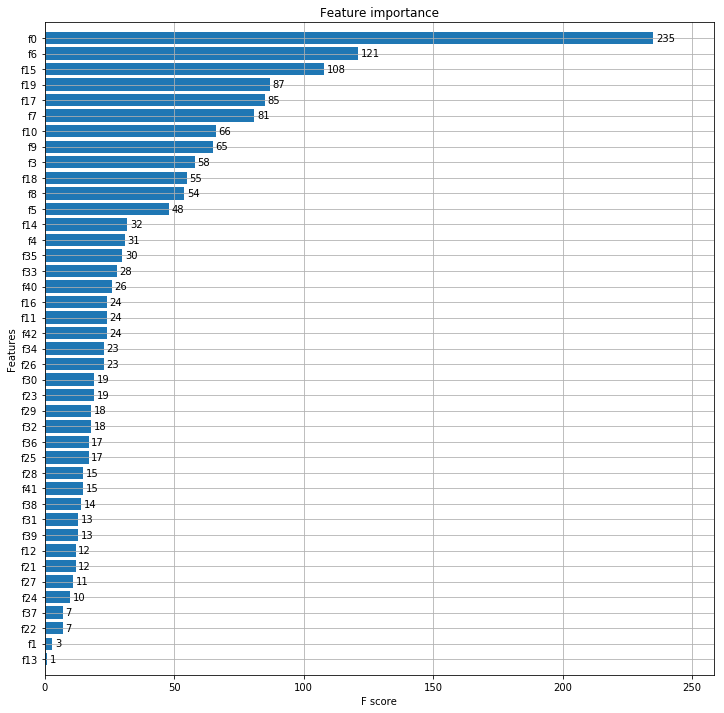

In [34]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()


In [35]:
 ##########################################Checking accuracy  on  5 cross   validations###############################

In [36]:
from sklearn.metrics import accuracy_score

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
for cross  in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=cross)
    model=xgb.XGBClassifier(n_estimators=250)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    print(accuracy_score(y_test,pred))
    
     
    

0.637931034483
0.591133004926
0.603448275862
0.610837438424
0.620689655172


In [39]:
np.unique(pred,return_counts=True)

(array([False,  True], dtype=bool), array([138, 268]))

In [40]:
from sklearn.ensemble import  RandomForestClassifier
for cross  in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=cross)
    model=RandomForestClassifier(n_estimators=100)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    print(accuracy_score(y_test,pred))
    
     
    

0.630541871921
0.637931034483
0.625615763547
0.642857142857
0.620689655172


Feature ranking:
1. feature 1 (0.100927)
2. feature 0 (0.100743)
3. feature 6 (0.049747)
4. feature 15 (0.047182)
5. feature 4 (0.042666)
6. feature 3 (0.042642)
7. feature 17 (0.042406)
8. feature 19 (0.042213)
9. feature 5 (0.041583)
10. feature 8 (0.040685)
11. feature 14 (0.039222)
12. feature 9 (0.039112)
13. feature 18 (0.038256)
14. feature 7 (0.037082)
15. feature 10 (0.036494)
16. feature 16 (0.034427)
17. feature 31 (0.012093)
18. feature 35 (0.011928)
19. feature 28 (0.011654)
20. feature 29 (0.011549)
21. feature 26 (0.011526)
22. feature 41 (0.011374)
23. feature 34 (0.011248)
24. feature 36 (0.011054)
25. feature 38 (0.010725)
26. feature 37 (0.010648)
27. feature 23 (0.010524)
28. feature 30 (0.010375)
29. feature 40 (0.010255)
30. feature 32 (0.010174)
31. feature 24 (0.010093)
32. feature 33 (0.009898)
33. feature 27 (0.009608)
34. feature 42 (0.009447)
35. feature 39 (0.009060)
36. feature 25 (0.008904)
37. feature 22 (0.003381)
38. feature 21 (0.003168)
39. feature 1

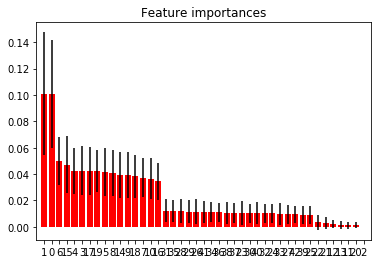

In [41]:
forest=model
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [52]:
import numpy as np
import GPy
import GPyOpt
from xgboost import XGBClassifier
from sklearn.cross_validation import cross_val_score
y=y.astype(int)

In [53]:

def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
                XGBClassifier(learning_rate=parameters[0],
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              gamma=int(parameters[1]),
                              min_child_weight = parameters[4]), 
                X, y, scoring='accuracy').mean()
    score = np.array(score)
    return score
baseline = -cross_val_score(XGBClassifier(), X, y, scoring='accuracy').mean()
baseline

-0.60410502386393772

In [58]:
bounds = [
            {'name': 'learning_rate', 'type': 'continuous', 'domain': (1e-5, 1)},
            {'name': 'gamma', 'type': 'continuous', 'domain': (1e-5, 5)},
            {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
            {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 1000)},
            {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}
         ]

np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds,
                                                acquisition_type ='MPI',
                                                acquisition_par = 0.1,
                                                exact_eval=True)
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

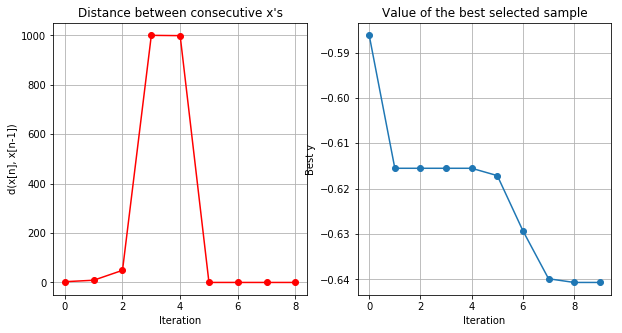

In [59]:

optimizer.plot_convergence()

In [64]:
np.set_printoptions(suppress=True)
optimizer.X[np.argmin(optimizer.Y)]

array([    0.33589572,     4.8989112 ,    50.        ,  1000.        ,
          10.        ])

In [61]:
np.min(optimizer.Y)

-0.6406668263673696

In [65]:
for cross  in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=cross)
    model=xgb.XGBClassifier(n_estimators=1000,learning_rate=0.33589572,gamma=4.8989112,
                           max_depth= 50,min_child_weight=10)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    print(accuracy_score(y_test,pred))
    
     
    

0.645320197044
0.613300492611
0.642857142857
0.662561576355
0.628078817734


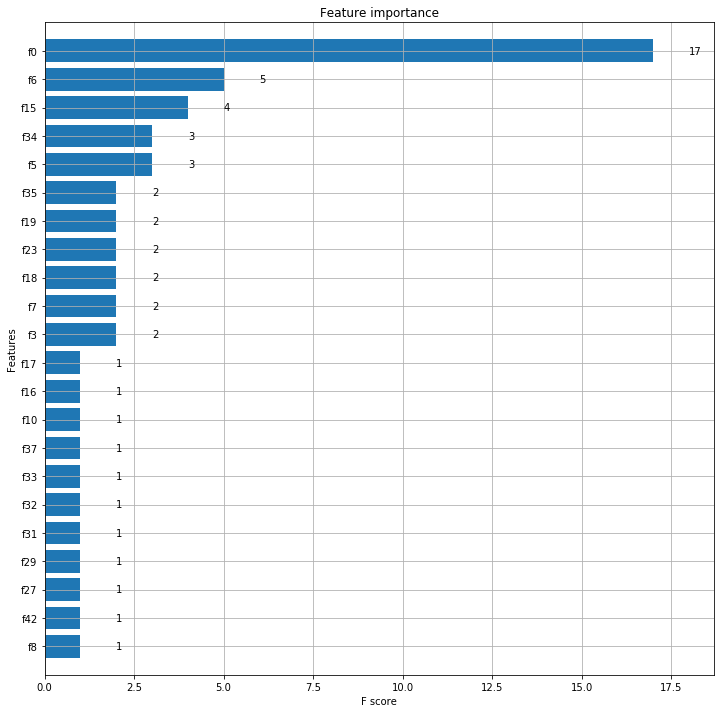

In [66]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()
